In [1]:
from Indexed_Dataset import *
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import random
from torch.utils.data import WeightedRandomSampler

In [2]:
torch.manual_seed(42)
np.random.seed(42)
# torch.use_deterministic_algorithms(True)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

In [3]:
train_arr = np.loadtxt("../data/no_coord_train.csv", dtype=np.float32, delimiter=",", skiprows=1)
print(train_arr[:, 0])
mean = train_arr[:, -1].mean()
std = train_arr[:, -1].std()
train_arr = train_arr[train_arr[:, -1] < mean + 5 * std]
train_arr = train_arr[train_arr[:, -1] > 50]
# Split into training/validation sets
np.random.shuffle(train_arr)
valid_arr = train_arr[int(0.9 * train_arr.shape[0]):]
train_arr = train_arr[:int(0.9 * train_arr.shape[0])]
weights = train_arr[:, -1]

sampler = WeightedRandomSampler(weights=weights, num_samples=train_arr.shape[0], replacement=True)

train_set = Indexed_Dataset(arr=train_arr)
train_load = DataLoader(dataset=train_set,
                        batch_size=32,
#                         sampler=sampler,
                        shuffle=True,
                        num_workers=8,
                        worker_init_fn=seed_worker,
                        generator=g,)

valid_set = Indexed_Dataset(arr=valid_arr)
valid_load = DataLoader(dataset=valid_set,
                        batch_size=32,
                        # num_workers=8,
                        shuffle=True,
                        worker_init_fn=seed_worker,
                        generator=g,)

device = "cuda" if torch.cuda.is_available() else "cpu"

[0.000000e+00 1.000000e+00 2.000000e+00 ... 1.710667e+06 1.710668e+06
 1.710669e+06]


In [4]:
class TravelRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        origin_call_dim = 20
        origin_stand_dim = 5
        taxi_id_dim = 10
        self.embed_origin_call: nn.Module = nn.Embedding(29027, origin_call_dim, padding_idx=0)
        self.embed_origin_stand: nn.Module = nn.Embedding(64, origin_stand_dim)
        self.embed_taxi_id: nn.Module = nn.Embedding(448, taxi_id_dim)
        self.feed_forward = nn.Sequential(
            nn.Linear(9 + origin_call_dim + origin_stand_dim + taxi_id_dim, 1000),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1000, 800),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(800, 1)
        )

    def forward(self, input: torch.Tensor):
        origin_call = self.embed_origin_call(input[:, 0].to(dtype=torch.int32))
        origin_stand = self.embed_origin_stand(input[:, 1].to(dtype=torch.int32))
        taxi_id = self.embed_taxi_id(input[:, 2].to(dtype=torch.int32))
        input = torch.cat((origin_call, origin_stand, taxi_id, input[:, 3:]), dim=1).to(dtype=torch.float32)
        input = self.feed_forward(input)
        return input

model = TravelRegressor().to(device)

In [5]:
model.eval()
model(train_set[0][0].unsqueeze(0).to(device)).size()
# train_set[0][0].unsqueeze(0).size()

torch.Size([1, 1])

In [6]:
mse = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
def weight_mse(pred, act):
    denom = torch.sum(act)
    return torch.sum(act * ((pred - act)**2 / len(act))) / denom

In [8]:
def validate():
    model.eval()
    loss = torch.tensor([0]).to(device, dtype=torch.float32)
    with torch.no_grad():
        for i, (entry, target) in enumerate(valid_load):
            entry = entry.to(device, dtype=torch.float32)
            target = target.to(device, dtype=torch.float32)
            preds = model(entry)
            loss += mse(preds, target)

    return loss /(i + 1)

In [9]:
rmse_loss = []
valid_loss = []
def train(num_iter: int):
    for epoch in range(num_iter):
        rolling_loss = 0
        entries = 0
        for i, (entry, target) in enumerate(train_load):
            model.train()
            entry = entry.to(device, dtype=torch.float32)
            target = target.to(device, dtype=torch.float32)
            preds = model(entry)

            optimizer.zero_grad()
            loss = mse(preds, target) # or weighted mse
            loss.backward()
            optimizer.step()
            rolling_loss += mse(preds, target) * entry.size(0)
            entries += entry.size(0)
            if (i + 1) % 500 == 0 or i == 0:
                rolling_loss /= entries
                print(f"[Epoch: {epoch + 1}]\t[Iter: {i + 1}]\t[RMSE: {torch.sqrt(rolling_loss)}]\t[STD: {torch.std(preds).item()}]")
                rmse_loss.append(torch.sqrt(rolling_loss).item())
                valid_loss.append(torch.sqrt(validate()).item())
                entries = 0
                rolling_loss = 0


In [10]:
train(1)

[Epoch: 1]	[Iter: 1]	[RMSE: 904.6311645507812]	[STD: 1.220678687095642]
[Epoch: 1]	[Iter: 500]	[RMSE: 483.912109375]	[STD: 128.19338989257812]
[Epoch: 1]	[Iter: 1000]	[RMSE: 460.364990234375]	[STD: 102.03137969970703]
[Epoch: 1]	[Iter: 1500]	[RMSE: 454.1444396972656]	[STD: 132.04541015625]
[Epoch: 1]	[Iter: 2000]	[RMSE: 445.71112060546875]	[STD: 125.44325256347656]
[Epoch: 1]	[Iter: 2500]	[RMSE: 450.5604553222656]	[STD: 120.10313415527344]
[Epoch: 1]	[Iter: 3000]	[RMSE: 455.60052490234375]	[STD: 119.15948486328125]
[Epoch: 1]	[Iter: 3500]	[RMSE: 440.59979248046875]	[STD: 118.45662689208984]
[Epoch: 1]	[Iter: 4000]	[RMSE: 446.5441589355469]	[STD: 107.38921356201172]
[Epoch: 1]	[Iter: 4500]	[RMSE: 450.65899658203125]	[STD: 138.66151428222656]
[Epoch: 1]	[Iter: 5000]	[RMSE: 442.819091796875]	[STD: 120.94920349121094]
[Epoch: 1]	[Iter: 5500]	[RMSE: 436.3639221191406]	[STD: 132.7995147705078]
[Epoch: 1]	[Iter: 6000]	[RMSE: 450.7597961425781]	[STD: 96.7884750366211]
[Epoch: 1]	[Iter: 6500]	[

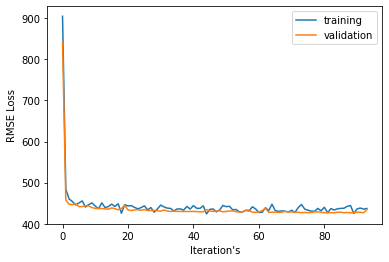

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(rmse_loss, label="training")
plt.plot(valid_loss, label="validation")
plt.xlabel("Iteration's")
plt.ylabel("RMSE Loss")
plt.legend()
plt.show()

In [12]:
torch.sqrt(validate()).item()

426.50860595703125

### Milestone part 3 getting top 10 data points with greatest training loss

In [13]:
train_tensor = torch.from_numpy(train_arr).to(device)

In [14]:
torch.cuda.empty_cache()
import gc
# del variables
gc.collect()
# Ran into CUDA out of memory :(

3386

In [15]:
eval_load = DataLoader(dataset=train_set,
                        batch_size=32,
#                         sampler=sampler,
                        shuffle=False, # I just disabled shuffling
                        num_workers=8,
                        worker_init_fn=seed_worker,
                        generator=g,)
model.eval()
full_loss = np.zeros(len(train_set))
total = 0
batchsz = 0
with torch.no_grad():
    for i, (entry, target) in enumerate(eval_load):
        entry = entry.to(device, dtype=torch.float32)
        target = target.to(device, dtype=torch.float32)
        preds = model(entry)
        batchsz = target.size()[0]
        full_loss[total:total + batchsz] = np.sqrt((preds.cpu().numpy() - target.cpu().numpy())**2)[:, 0]
        total += target.size()[0]

In [16]:
order = np.argsort(full_loss)
print(order[-10:]) # 10 worst loss data points
print(full_loss[order[-10:]])
print(train_arr[order[-10:], 0]) # indices in original dataset

[ 312078 1126849  109034  135649 1436240  108166  876270  770785 1372843
 1399250]
[3549.31518555 3583.26391602 3594.75244141 3595.67797852 3598.5246582
 3604.25708008 3614.87329102 3620.29956055 3669.8737793  3694.53271484]
[ 246099.  737684. 1162019.  498709.  183950.   30871.  811174.  825096.
  454547.  356296.]


In [17]:
max(train_arr[:, 0])

1710669.0

In [18]:
eval_arr[train_arr[:, 0].astype(np.int32), 0]

NameError: name 'eval_arr' is not defined

In [ ]:
train_arr.shape

In [19]:
eval_arr = np.loadtxt("../data/no_coord_train.csv", dtype=np.float32, delimiter=",", skiprows=1)
eval_set = Indexed_Dataset(arr=eval_arr)
eval_load = DataLoader(dataset=eval_set,
                        batch_size=32,
#                         sampler=sampler,
                        shuffle=False, # I just disabled shuffling
                        num_workers=8,
                        worker_init_fn=seed_worker,
                        generator=g,)
model.eval()
full_loss = np.zeros(len(eval_set))
total = 0
batchsz = 0
with torch.no_grad():
    for i, (entry, target) in enumerate(eval_load):
        entry = entry.to(device, dtype=torch.float32)
        target = target.to(device, dtype=torch.float32)
        preds = model(entry)
        batchsz = target.size()[0]
        full_loss[total:total + batchsz] = np.sqrt((preds.cpu().numpy() - target.cpu().numpy())**2)[:, 0]
        total += target.size()[0]


In [20]:
order = np.argsort(full_loss)
print(len(order))
print(full_loss[order[-10:]])
print(order[-10:]) # 10 worst loss data points
eval_arr[order[-10:], 0] # indices in original dataset

1710660
[38849.01953125 38992.9609375  39716.15625    43418.04296875
 45445.9140625  52402.1328125  53240.76171875 56979.97265625
 57086.9609375  57280.05078125]
[1003868  849524 1199131  182827  385816  147120  224508  578577 1492407
 1093719]


array([1003876.,  849531., 1199139.,  182829.,  385819.,  147121.,
        224510.,  578581., 1492417., 1093727.], dtype=float32)

In [ ]:
# model.eval()
# with torch.no_grad():
#     test = torch.from_numpy(np.loadtxt("../data/no_coord_test.csv", skiprows=1, dtype=np.float32, delimiter=",")).to(device)
#     out = model(test)
#     torch.set_printoptions(threshold=10000, sci_mode=False)
#     df_pred = pd.read_csv("../data/sampleSubmission.csv")
#     df_pred["TRAVEL_TIME"] = out.cpu().numpy()
#     df_pred.to_csv("NN_nocoord_weighted_prune.csv")